# Importation des packages

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Réseaux de neurones
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


# Etude du jeu de données

In [18]:
print(data.shape[0])

159571


In [12]:
data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


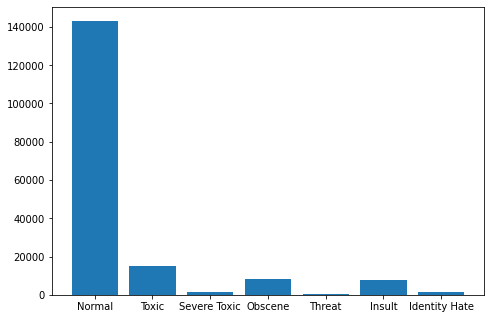

In [16]:
types = ["Normal", "Toxic", "Severe Toxic", "Obscene", "Threat", "Insult", "Identity Hate"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])


labels = data.columns[2:]

values = [len(data[(data['toxic'] == 0) & (data['severe_toxic'] == 0) & (data['obscene'] == 0) & (data['threat'] == 0) & (data['insult'] == 0) & (data['identity_hate'] == 0)])]
for column in labels:
  values.append(data[column].value_counts().to_numpy()[1])
ax.bar(types,values)
plt.show()

# Préparation des données

In [17]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
variable_name = ""
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

def convert_abbrev_in_text(comment):
    t=[]
    words=comment.split()
    t = [abbreviations[w.lower()] if w.lower() in abbreviations.keys() else w for w in words]
    return ' '.join(t)

In [20]:
def clean(comment): 
            
    # Contractions
    comment = re.sub(r"he's", "he is", comment)
    comment = re.sub(r"there's", "there is", comment)
    comment = re.sub(r"We're", "We are", comment)
    comment = re.sub(r"That's", "That is", comment)
    comment = re.sub(r"won't", "will not", comment)
    comment = re.sub(r"they're", "they are", comment)
    comment = re.sub(r"Can't", "Cannot", comment)
    comment = re.sub(r"wasn't", "was not", comment)
    comment = re.sub(r"don\x89Ûªt", "do not", comment)
    comment = re.sub(r"aren't", "are not", comment)
    comment = re.sub(r"isn't", "is not", comment)
    comment = re.sub(r"What's", "What is", comment)
    comment = re.sub(r"haven't", "have not", comment)
    comment = re.sub(r"hasn't", "has not", comment)
    comment = re.sub(r"There's", "There is", comment)
    comment = re.sub(r"He's", "He is", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"You're", "You are", comment)
    comment = re.sub(r"I'M", "I am", comment)
    comment = re.sub(r"shouldn't", "should not", comment)
    comment = re.sub(r"wouldn't", "would not", comment)
    comment = re.sub(r"i'm", "I am", comment)
    comment = re.sub(r"I\x89Ûªm", "I am", comment)
    comment = re.sub(r"I'm", "I am", comment)
    comment = re.sub(r"Isn't", "is not", comment)
    comment = re.sub(r"Here's", "Here is", comment)
    comment = re.sub(r"you've", "you have", comment)
    comment = re.sub(r"you\x89Ûªve", "you have", comment)
    comment = re.sub(r"we're", "we are", comment)
    comment = re.sub(r"what's", "what is", comment)
    comment = re.sub(r"couldn't", "could not", comment)
    comment = re.sub(r"we've", "we have", comment)
    comment = re.sub(r"it\x89Ûªs", "it is", comment)
    comment = re.sub(r"doesn\x89Ûªt", "does not", comment)
    comment = re.sub(r"It\x89Ûªs", "It is", comment)
    comment = re.sub(r"Here\x89Ûªs", "Here is", comment)
    comment = re.sub(r"who's", "who is", comment)
    comment = re.sub(r"I\x89Ûªve", "I have", comment)
    comment = re.sub(r"y'all", "you all", comment)
    comment = re.sub(r"can\x89Ûªt", "cannot", comment)
    comment = re.sub(r"would've", "would have", comment)
    comment = re.sub(r"it'll", "it will", comment)
    comment = re.sub(r"we'll", "we will", comment)
    comment = re.sub(r"wouldn\x89Ûªt", "would not", comment)
    comment = re.sub(r"We've", "We have", comment)
    comment = re.sub(r"he'll", "he will", comment)
    comment = re.sub(r"Y'all", "You all", comment)
    comment = re.sub(r"Weren't", "Were not", comment)
    comment = re.sub(r"Didn't", "Did not", comment)
    comment = re.sub(r"they'll", "they will", comment)
    comment = re.sub(r"they'd", "they would", comment)
    comment = re.sub(r"DON'T", "DO NOT", comment)
    comment = re.sub(r"That\x89Ûªs", "That is", comment)
    comment = re.sub(r"they've", "they have", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"should've", "should have", comment)
    comment = re.sub(r"You\x89Ûªre", "You are", comment)
    comment = re.sub(r"where's", "where is", comment)
    comment = re.sub(r"Don\x89Ûªt", "Do not", comment)
    comment = re.sub(r"we'd", "we would", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"weren't", "were not", comment)
    comment = re.sub(r"They're", "They are", comment)
    comment = re.sub(r"Can\x89Ûªt", "Cannot", comment)
    comment = re.sub(r"you\x89Ûªll", "you will", comment)
    comment = re.sub(r"I\x89Ûªd", "I would", comment)
    comment = re.sub(r"let's", "let us", comment)
    comment = re.sub(r"it's", "it is", comment)
    comment = re.sub(r"can't", "cannot", comment)
    comment = re.sub(r"don't", "do not", comment)
    comment = re.sub(r"you're", "you are", comment)
    comment = re.sub(r"i've", "I have", comment)
    comment = re.sub(r"that's", "that is", comment)
    comment = re.sub(r"i'll", "I will", comment)
    comment = re.sub(r"doesn't", "does not", comment)
    comment = re.sub(r"i'd", "I would", comment)
    comment = re.sub(r"didn't", "did not", comment)
    comment = re.sub(r"ain't", "am not", comment)
    comment = re.sub(r"you'll", "you will", comment)
    comment = re.sub(r"I've", "I have", comment)
    comment = re.sub(r"Don't", "do not", comment)
    comment = re.sub(r"I'll", "I will", comment)
    comment = re.sub(r"I'd", "I would", comment)
    comment = re.sub(r"Let's", "Let us", comment)
    comment = re.sub(r"you'd", "You would", comment)
    comment = re.sub(r"It's", "It is", comment)
    comment = re.sub(r"Ain't", "am not", comment)
    comment = re.sub(r"Haven't", "Have not", comment)
    comment = re.sub(r"Could've", "Could have", comment)
    comment = re.sub(r"youve", "you have", comment)  
    comment = re.sub(r"donå«t", "do not", comment)  
    
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"yrs", "years", comment)
    comment = re.sub(r"hrs", "hours", comment)
    comment = re.sub(r"2morow|2moro", "tomorrow", comment)
    comment = re.sub(r"2day", "today", comment)
    comment = re.sub(r"4got|4gotten", "forget", comment)
    comment = re.sub(r"b-day|bday", "b-day", comment)
    comment = re.sub(r"mother's", "mother", comment)
    comment = re.sub(r"mom's", "mom", comment)
    comment = re.sub(r"dad's", "dad", comment)
    comment = re.sub(r"hahah|hahaha|hahahaha", "haha", comment)
    comment = re.sub(r"lmao|lolz|rofl", "lol", comment)
    comment = re.sub(r"thanx|thnx", "thanks", comment)
    comment = re.sub(r"goood", "good", comment)
    comment = re.sub(r"some1", "someone", comment)
    comment = re.sub(r"some1", "someone", comment)
    # Character entity references
    comment = re.sub(r"&gt;", ">", comment)
    comment = re.sub(r"&lt;", "<", comment)
    comment = re.sub(r"&amp;", "&", comment)
    # Typos, slang and informal abbreviations
    comment = re.sub(r"w/e", "whatever", comment)
    comment = re.sub(r"w/", "with", comment)
    comment = re.sub(r"<3", "love", comment)
    # Urls
    comment = re.sub(r"http\S+", "", comment)
    # Numbers
    comment = re.sub(r'[0-9]', '', comment)
    # Eliminating the mentions
    comment = re.sub("(@[A-Za-z0-9_]+)","", comment)
    # Remove punctuation and special chars (keep '!')
    for p in string.punctuation.replace('!', ''):
        comment = comment.replace(p, '')
        
    # ... and ..
    comment = comment.replace('...', ' ... ')
    if '...' not in comment:
        comment = comment.replace('..', ' ... ')
        
    # Tokenize
    comment_words = word_tokenize(comment)
    
    # Eliminating the word if its length is less than 3
    comment = [w for w in comment_words if len(w)>2]
    
    # remove stopwords
    comment = [w.lower() for w in comment if not w in stop_words]  
    
    
    # join back
    comment = ' '.join(comment)
        
        
    return comment

# Passage du texte dans un format structuré

In [ ]:
# Your Code

# Entraînement du modèle baseline

In [ ]:
# Your Code

# Itération de la modélisation 

In [ ]:
# Your Code 